<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/NODE_(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Step 1: Libraries imported and random seeds set")
print("=" * 50)


Step 1: Libraries imported and random seeds set


In [76]:

# Step 2: Define NODE Model Class
class NODEModel:
    """
    Neural Oblivious Decision Ensembles (NODE) implementation
    """

    def __init__(self, input_dim, num_classes, num_layers=3, tree_depth=6, num_trees=2048,
                 learning_rate=0.001, batch_size=512):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.tree_depth = tree_depth
        self.num_trees = num_trees
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = None
        self.history = None

    def build_model(self):
        """Build the NODE model architecture"""
        inputs = layers.Input(shape=(self.input_dim,))

        # Feature preprocessing
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        # NODE layers (simplified implementation)
        for i in range(self.num_layers):
            # Oblivious decision tree simulation
            choice_function = layers.Dense(2**self.tree_depth, activation='sigmoid')(x)
            feature_selection = layers.Dense(self.tree_depth, activation='softmax')(x)

            # Tree ensemble
            tree_outputs = []
            for j in range(min(8, self.num_trees // (2**i + 1))):  # Reduced for computational efficiency
                tree_branch = layers.Dense(64, activation='relu')(x)
                tree_branch = layers.Dropout(0.2)(tree_branch)
                tree_outputs.append(tree_branch)

            if tree_outputs:
                x = layers.Add()(tree_outputs) if len(tree_outputs) > 1 else tree_outputs[0]

            x = layers.Dense(128, activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.2)(x)

        # Final classification layer
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        self.model = keras.Model(inputs=inputs, outputs=outputs)

        # Compile model
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, verbose=1):
        """Train the NODE model"""
        if self.model is None:
            self.build_model()

        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=15, restore_best_weights=True
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6
        )

        # Train model
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=self.batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=verbose
        )

        return self.history

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X)

    def predict_classes(self, X):
        """Predict class labels"""
        predictions = self.predict(X)
        return np.argmax(predictions, axis=1)

print("Step 2: NODE Model class defined")
print("=" * 50)


Step 2: NODE Model class defined


In [77]:

# Step 3: Define Data Loading Function
def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    print("Loading data...")

    # Load datasets
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Validation shape: {val_df.shape}")
    print(f"Test shape: {test_df.shape}")

    return train_df, val_df, test_df

print("Step 3: Data loading function defined")
print("=" * 50)


Step 3: Data loading function defined


In [78]:

# Step 4: Define Label Creation Function
def create_quantile_labels(df, target_col='Production (M.Ton)'):
    """Create quantile-based labels for production (3 classes)"""
    print("Creating quantile-based labels (3 classes)...")

    # Calculate terciles (33rd and 67th percentiles)
    quantiles = df[target_col].quantile([0.33, 0.67]).values
    print(f"Tercile thresholds: {quantiles}")

    # Create labels
    def get_label(value):
        if value <= quantiles[0]:
            return 0  # Low
        elif value <= quantiles[1]:
            return 1  # Medium
        else:
            return 2  # High

    labels = df[target_col].apply(get_label)

    # Print label distribution
    label_names = ['Low', 'Medium', 'High']
    print("Label distribution:")
    for i, name in enumerate(label_names):
        count = (labels == i).sum()
        print(f"{name}: {count} ({count/len(labels)*100:.1f}%)")

    return labels, quantiles

print("Step 4: Label creation function defined")
print("=" * 50)


Step 4: Label creation function defined


In [79]:

# Step 5: Define Feature Preprocessing Function
def preprocess_features(train_df, val_df, test_df, target_col='Production (M.Ton)'):
    """Preprocess features and prepare data for training"""
    print("Preprocessing features...")

    # Separate features and target
    feature_cols = [col for col in train_df.columns if col != target_col]

    X_train = train_df[feature_cols].copy()
    X_val = val_df[feature_cols].copy()
    X_test = test_df[feature_cols].copy()

    # Create labels
    y_train, train_quantiles = create_quantile_labels(train_df, target_col)

    # Use train quantiles for validation and test sets
    def apply_train_quantiles(df, quantiles, target_col):
        def get_label(value):
            if value <= quantiles[0]:
                return 0  # Low
            elif value <= quantiles[1]:
                return 1  # Medium
            else:
                return 2  # High
        return df[target_col].apply(get_label)

    y_val = apply_train_quantiles(val_df, train_quantiles, target_col)
    y_test = apply_train_quantiles(test_df, train_quantiles, target_col)

    # Handle missing values
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_train.mean())  # Use train mean for validation
    X_test = X_test.fillna(X_train.mean())  # Use train mean for test

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Feature dimensions: {X_train_scaled.shape[1]}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    return (X_train_scaled, y_train, X_val_scaled, y_val,
            X_test_scaled, y_test, scaler, train_quantiles)

print("Step 5: Feature preprocessing function defined")
print("=" * 50)


Step 5: Feature preprocessing function defined


In [80]:

# Step 6: Define Metrics Calculation Function
def calculate_metrics(y_true, y_pred, dataset_name=""):
    """Calculate comprehensive classification metrics"""
    print(f"\n{dataset_name} Classification Metrics:")
    print("-" * 50)

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"Recall (Weighted): {recall_weighted:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    # Detailed classification report
    print(f"\nDetailed Classification Report ({dataset_name}):")
    class_names = ['Low', 'Medium', 'High']
    print(classification_report(y_true, y_pred, target_names=class_names))

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

print("Step 6: Metrics calculation function defined")
print("=" * 50)


Step 6: Metrics calculation function defined


In [81]:

# Step 7: Define Confusion Matrix Plot Function
def plot_confusion_matrix(y_true, y_pred, dataset_name="", figsize=(5, 4)):
    """Plot confusion matrix"""
    plt.figure(figsize=figsize)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Low', 'Medium', 'High']

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return cm

print("Step 7: Confusion matrix plot function defined")
print("=" * 50)


Step 7: Confusion matrix plot function defined


In [82]:

# Step 8: Define Training History Plot Function
def plot_training_history(history, metric='accuracy'):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label=f'Training {metric.title()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.title()}')
    plt.title(f'Model {metric.title()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("Step 8: Training history plot function defined")
print("=" * 50)

# EXECUTION STEPS
# Now you can run these steps one by one:


Step 8: Training history plot function defined


In [83]:

# STEP 9: Load Data
print("\nSTEP 9: Loading and preprocessing data...")
print("NODE (Neural Oblivious Decision Ensembles) for Agricultural Production Classification - 3 Classes")
print("=" * 90)

# Load and preprocess data
train_df, val_df, test_df = load_and_preprocess_data()



STEP 9: Loading and preprocessing data...
NODE (Neural Oblivious Decision Ensembles) for Agricultural Production Classification - 3 Classes
Loading data...
Train shape: (3942, 84)
Validation shape: (845, 84)
Test shape: (845, 84)


In [84]:

# STEP 10: Preprocess Features
print("\nSTEP 10: Preprocessing features...")
(X_train, y_train, X_val, y_val,
 X_test, y_test, scaler, quantiles) = preprocess_features(train_df, val_df, test_df)



STEP 10: Preprocessing features...
Preprocessing features...
Creating quantile-based labels (3 classes)...
Tercile thresholds: [1071.5565 4035.9099]
Label distribution:
Low: 1301 (33.0%)
Medium: 1340 (34.0%)
High: 1301 (33.0%)
Feature dimensions: 83
Number of classes: 3


In [85]:
# STEP 11: Initialize NODE Model
print("\nSTEP 11: Initializing NODE model...")
node_model = NODEModel(
    input_dim=X_train.shape[1],
    num_classes=3,  # Changed to 3 classes
    num_layers=3,
    tree_depth=6,
    num_trees=1024,  # Reduced for computational efficiency
    learning_rate=0.001,
    batch_size=256
)



STEP 11: Initializing NODE model...


In [86]:

# STEP 12: Build Model
print("\nSTEP 12: Building model...")
model = node_model.build_model()
print(f"Model built with {model.count_params()} parameters")



STEP 12: Building model...
Model built with 236291 parameters


In [87]:

# STEP 13: Train Model
print("\nSTEP 13: Training NODE model...")
history = node_model.train(
    X_train, y_train,
    X_val, y_val,
    epochs=100,
    verbose=1
)



STEP 13: Training NODE model...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.3228 - loss: 1.5251 - val_accuracy: 0.3598 - val_loss: 1.7141 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3756 - loss: 1.2928 - val_accuracy: 0.3941 - val_loss: 1.2989 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3799 - loss: 1.2095 - val_accuracy: 0.4686 - val_loss: 1.0404 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3961 - loss: 1.1555 - val_accuracy: 0.4615 - val_loss: 1.0055 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4482 - loss: 1.0975 - val_accuracy: 0.5598 - val_loss: 0.9084 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5154 - loss: 1.0091 - val_accuracy: 0.5905 - val_loss: 0.8491 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - 


STEP 14: Plotting training history...


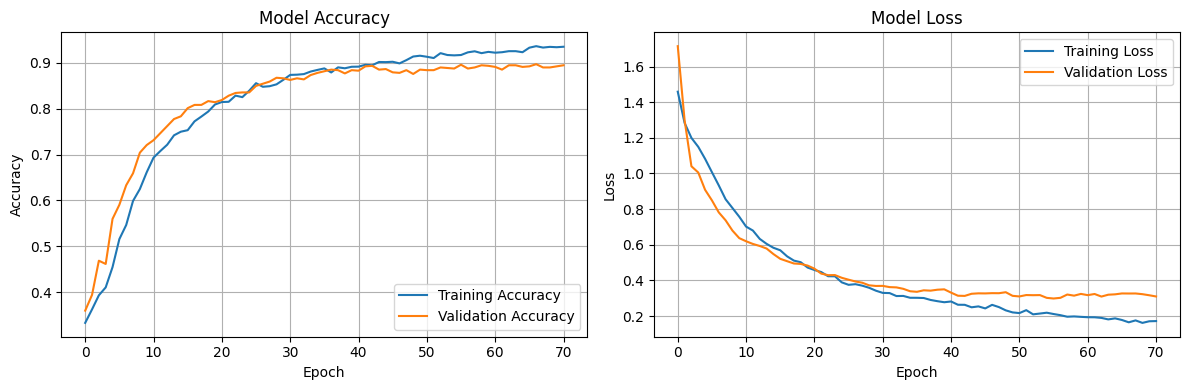

In [88]:

# STEP 14: Plot Training History
print("\nSTEP 14: Plotting training history...")
plot_training_history(history)


In [89]:

# STEP 15: Make Predictions
print("\nSTEP 15: Making predictions...")

# Validation predictions
val_pred_proba = node_model.predict(X_val)
val_pred = np.argmax(val_pred_proba, axis=1)

# Test predictions
test_pred_proba = node_model.predict(X_test)
test_pred = np.argmax(test_pred_proba, axis=1)



STEP 15: Making predictions...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [90]:

# STEP 16: Calculate Metrics
print("\nSTEP 16: Calculating metrics...")
val_metrics = calculate_metrics(y_val, val_pred, "Validation")
test_metrics = calculate_metrics(y_test, test_pred, "Test")



STEP 16: Calculating metrics...

Validation Classification Metrics:
--------------------------------------------------
Accuracy: 0.8959
Precision (Macro): 0.8964
Precision (Weighted): 0.8956
Recall (Macro): 0.8969
Recall (Weighted): 0.8959
F1 Score (Macro): 0.8966
F1 Score (Weighted): 0.8957

Detailed Classification Report (Validation):
              precision    recall  f1-score   support

         Low       0.94      0.95      0.95       278
      Medium       0.86      0.85      0.85       297
        High       0.89      0.89      0.89       270

    accuracy                           0.90       845
   macro avg       0.90      0.90      0.90       845
weighted avg       0.90      0.90      0.90       845


Test Classification Metrics:
--------------------------------------------------
Accuracy: 0.9302
Precision (Macro): 0.9299
Precision (Weighted): 0.9300
Recall (Macro): 0.9302
Recall (Weighted): 0.9302
F1 Score (Macro): 0.9300
F1 Score (Weighted): 0.9300

Detailed Classification


STEP 17: Generating confusion matrices...


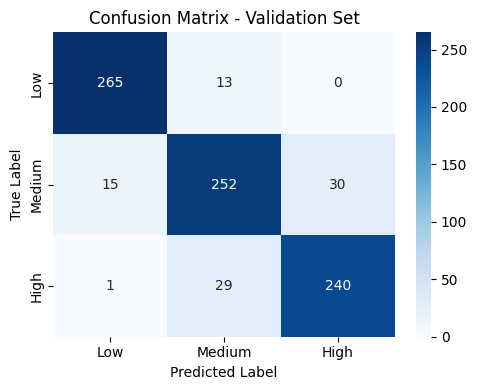

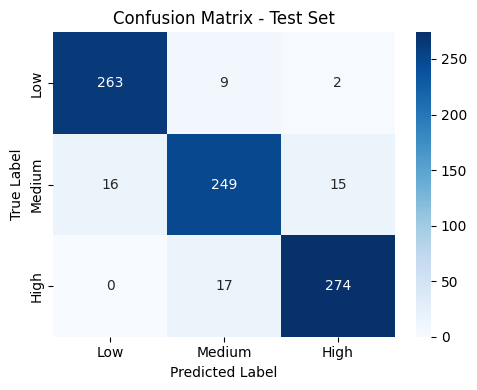

In [91]:

# STEP 17: Plot Confusion Matrices
print("\nSTEP 17: Generating confusion matrices...")
val_cm = plot_confusion_matrix(y_val, val_pred, "Validation Set")
test_cm = plot_confusion_matrix(y_test, test_pred, "Test Set")


In [92]:

# STEP 18: Display Final Results Summary
print("\n" + "="*80)
print("STEP 18: FINAL RESULTS SUMMARY")
print("="*80)
print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Validation Macro F1: {val_metrics['f1_macro']:.4f}")
print(f"Validation Weighted F1: {val_metrics['f1_weighted']:.4f}")
print()
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Macro F1: {test_metrics['f1_macro']:.4f}")
print(f"Test Weighted F1: {test_metrics['f1_weighted']:.4f}")

# Quantile information
print(f"\nTercile Thresholds Used:")
labels = ['Low', 'Medium', 'High']
print(f"Low: ≤ {quantiles[0]:.3f}")
print(f"Medium: {quantiles[0]:.3f} - {quantiles[1]:.3f}")
print(f"High: > {quantiles[1]:.3f}")

print("\nModel training and evaluation completed successfully!")
print("="*80)


STEP 18: FINAL RESULTS SUMMARY
Validation Accuracy: 0.8959
Validation Macro F1: 0.8966
Validation Weighted F1: 0.8957

Test Accuracy: 0.9302
Test Macro F1: 0.9300
Test Weighted F1: 0.9300

Tercile Thresholds Used:
Low: ≤ 1071.556
Medium: 1071.556 - 4035.910
High: > 4035.910

Model training and evaluation completed successfully!
